In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
import pandas as pd
import torch

### Set base parameters

In [2]:
# 設定訓練參數
max_length = 32
batch_size = 16
#batch_size = 32
learning_rate = 1e-4
num_epochs = 10

pad_index = 0
mask_index = 103
sep_index = 102
cls_index = 101
unk_index = 100

dir_path = '.'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Load data

## Read sentence for each ALIGNED article csv file with train set and test set.

In [3]:
df_train_transcript = pd.read_csv('{}/CORPUS/HANJA/HANJA_TRAIN_ALL.csv'.format(dir_path))
df_train_transcript = df_train_transcript.to_dict(orient='dict')

TRAIN_KSENT = (list(df_train_transcript['KO'].values()))
TRAIN_KSENT.remove('\"')

TRAIN_ZSENT = (list(df_train_transcript['ZH'].values()))
TRAIN_ZSENT.remove('”')

TRAIN_HSENT = (list(df_train_transcript['HANJA_Z'].values()))
TRAIN_HSENT.remove('\"')

#TRAIN_HSENT = (list(df_train_transcript['HANJA_K'].values()))
#TRAIN_HSENT.remove('\"')

print(len(TRAIN_KSENT))
df_train_transcript = []

146660


In [4]:
df_test_transcript = pd.read_csv('{}/CORPUS/HANJA/HANJA_TEST_ALL.csv'.format(dir_path))
df_test_transcript = df_test_transcript.to_dict(orient='dict')

TEST_KSENT = (list(df_test_transcript['KO'].values()))
TEST_ZSENT = (list(df_test_transcript['ZH'].values()))
TEST_HSENT = (list(df_test_transcript['HANJA_Z'].values()))
#TEST_HSENT = (list(df_test_transcript['HANJA_K'].values()))

df_test_transcript = []
print(len(TEST_KSENT))

36089


In [5]:
df_train_zhuyin = pd.read_csv('./CORPUS/ZHUYIN/ZHUYIN_TRAIN_ALL.csv')
df_train_zhuyin = df_train_zhuyin.to_dict(orient='dict')

TRAIN_ZYSENT = (list(df_train_zhuyin['zhuyin'].values()))
TRAIN_ZYSENT.remove(np.nan)
TRAIN_ZYSENT = [sent.replace('\n','') for sent in TRAIN_ZYSENT]

df_train_zhuyin = []
print(len(TRAIN_ZYSENT))

146660


In [6]:
df_test_zhuyin = pd.read_csv('./CORPUS/ZHUYIN/ZHUYIN_TEST_ALL.csv')
df_test_zhuyin = df_test_zhuyin.to_dict(orient='dict')

TEST_ZYSENT = [sent.replace('\n','') for sent in (list(df_test_zhuyin['zhuyin'].values()))]

df_test_transcript = []
print(len(TEST_ZYSENT))

36089


In [7]:
def find_delete_indexs(src_lists,dst_lists):
    delete_indexs = {}
    for i in range(len(src_lists)):
        if(len(src_lists[i]) < 3 or len(dst_lists[i]) < 3):
            delete_indexs[i] = 1
            #print(i,src_lists[i], dst_lists[i])
    return list(delete_indexs.keys())

In [8]:
def delete_indexs_items(lists,delete_indexs):
    delete_indexs.reverse()
    for i in delete_indexs:
        del lists[i]
    return lists

In [9]:
train_del_idxs = find_delete_indexs(TRAIN_ZSENT,TRAIN_KSENT)
TRAIN_ZSENT = delete_indexs_items(TRAIN_ZSENT,train_del_idxs)
TRAIN_KSENT = delete_indexs_items(TRAIN_KSENT,train_del_idxs)
TRAIN_HSENT = delete_indexs_items(TRAIN_HSENT,train_del_idxs)
TRAIN_ZYSENT = delete_indexs_items(TRAIN_ZYSENT,train_del_idxs)
print(len(TRAIN_ZSENT),len(TRAIN_KSENT),len(TRAIN_HSENT),len(TRAIN_ZYSENT))

146612 146612 146612 146612


In [10]:
test_del_idxs = find_delete_indexs(TEST_ZSENT,TEST_KSENT)
TEST_ZSENT = delete_indexs_items(TEST_ZSENT,test_del_idxs)
TEST_KSENT = delete_indexs_items(TEST_KSENT,test_del_idxs)
TEST_HSENT = delete_indexs_items(TEST_HSENT,test_del_idxs)
TEST_ZYSENT = delete_indexs_items(TEST_ZYSENT,test_del_idxs)
print(len(TEST_ZSENT),len(TEST_KSENT),len(TEST_HSENT),len(TEST_ZYSENT))

36072 36072 36072 36072


In [163]:
print(TRAIN_ZYSENT[0])
print(TEST_ZYSENT[0])

ㄒㄧㄝˋㄒㄧㄝˋㄉㄚˋㄐㄧㄚ。
ㄨㄛˇㄒㄧㄤㄒㄧㄣˋㄖㄨˊㄍㄨㄛˇㄋㄧˇㄍㄟˇㄊㄚㄇㄣ˙ㄓㄥˋㄑㄩㄝˋㄉㄜ˙ㄈㄤㄈㄚˇㄏㄜˊㄍㄨㄥㄐㄩˋ，ㄊㄚㄇㄣ˙ㄎㄜˇㄧˇㄅㄚˇㄕㄢㄉㄡㄓㄨㄢˇㄧˊㄌㄜ˙ㄒㄧㄝˋㄒㄧㄝˋ（ㄍㄨˇㄓㄤˇㄕㄥ）


# Pretrain Model

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import Tensor
from torch.nn import Transformer

from transformers import BertTokenizer, BertModel, BertConfig, BertForPreTraining, AutoModel, BertTokenizerFast, BertForMaskedLM

import numpy as np
import matplotlib.pyplot as plt
import time
import math

## Load Tokenizer

In [18]:
import transformers
transformers.logging.set_verbosity_error() # solve the warning: 'Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.'

### Chinese Tokenizer

In [49]:
#zh_tokenizer = BertTokenizer.from_pretrained('{}/MODELS/TOKENIZER/new_zh_tokenizer_add_bpmf_korean_tokens_v2'.format(dir_path) )# load bert-base-chinese tokenizer with bpmf、hangul tokens(from 'kykim/bert-kor-base' and konlpy)
zh_tokenizer = BertTokenizerFast.from_pretrained('bert-base-chinese')

In [12]:
# zhuyin tokens
import re
zhuyins = ['ㄅ','ㄆ','ㄇ','ㄈ','ㄉ','ㄊ','ㄋ','ㄌ','ㄍ','ㄎ','ㄏ','ㄐ','ㄑ','ㄒ','ㄓ','ㄔ','ㄕ','ㄖ','ㄗ','ㄘ','ㄙ','ㄧ','ㄨ','ㄩ','ㄚ','ㄛ','ㄜ','ㄝ','ㄞ','ㄟ','ㄠ','ㄡ','ㄢ','ㄣ','ㄤ','ㄥ','ㄦ','ˇ','ˋ','ˊ','˙']

def check_bpmf_is_not(text):
    test_list = ['.*[ㄅㄆㄇㄈㄉㄊㄋㄌㄍㄎㄏㄐㄑㄒㄓㄔㄕㄖㄗㄘㄙㄧㄨㄩㄚㄛㄜㄝㄞㄟㄠㄡㄢㄣㄤㄥㄦˇˋˊ˙]+.*']
    for t in test_list:
        valid = re.compile(t)
        try:
            if(valid.match(text) != None):
                return True
        except:
            return False
    return False

zhuyin_df = pd.read_csv('{}/CORPUS/TOKEN/zhuyin_tokens_count.csv'.format(dir_path))
zhuyin_df = zhuyin_df.to_dict(orient='dict')
zhuyin_tokens = list(zhuyin_df['zhuyin'].values())
print(len(zhuyin_tokens))

for tok in zhuyin_tokens:
  if(check_bpmf_is_not(tok)):
    continue
  else:
    zhuyin_tokens.remove(tok)
print('zy:',len(zhuyins))
print('zy tokens:',len(zhuyin_tokens))

2751
zy: 41
zy tokens: 2089


In [13]:
# korean tokens
ko_tokenizer = BertTokenizerFast.from_pretrained("kykim/bert-kor-base")
ko_tokenizer_tokens = list(ko_tokenizer.get_vocab().keys())
print(len(ko_tokenizer_tokens))

42000


In [14]:
# add new tokens
zh_tokenizer = BertTokenizerFast.from_pretrained('bert-base-chinese')
print('Original Length: ',len(zh_tokenizer))

zh_tokenizer.add_tokens(zhuyins)
print('Add zhuyins: ',len(zh_tokenizer))

zh_tokenizer.add_tokens(zhuyin_tokens)
print('Add zhuyin tokens: ',len(zh_tokenizer))

zh_tokenizer.add_tokens(ko_tokenizer_tokens)
print('Add korean tokens from kykim/bert-kor-base tokenizer: ',len(zh_tokenizer))

Original Length:  21128
Add zhuyins:  21146
Add zhuyin tokens:  22839
Add korean tokens from kykim/bert-kor-base tokenizer:  63662


In [15]:
zh_bert_model = AutoModel.from_pretrained('ckiplab/bert-base-chinese')
zh_bert_model.resize_token_embeddings(len(zh_tokenizer))

Some weights of BertModel were not initialized from the model checkpoint at ckiplab/bert-base-chinese and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Embedding(63662, 768)

### Korean Tokenizer

In [47]:
ko_tokenizer = BertTokenizerFast.from_pretrained("kykim/bert-kor-base")

In [48]:
ko_bert_model = BertModel.from_pretrained("kykim/bert-kor-base")

### mbert

In [25]:
mbert_tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

In [26]:
mbert_model = BertModel.from_pretrained('bert-base-multilingual-cased').to(device)
mbert_model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
 

### chinese bert with phonetic

In [58]:
my_model = zh_bert_model
tgt_model = ko_bert_model

my_model = my_model.to(device)
tgt_model = tgt_model.to(device)
#my_model.eval()

#tgt_model = zh_bert_model
my_tokenizer = zh_tokenizer
#tgt_tokenizer = zh_tokenizer
tgt_tokenizer =ko_tokenizer
#model_name = 'TF1_-_hanja_-_zy(test)' # zh_tokenizer+hanja+zy tokens
model_name = 'TF1_-_hanja_-_zy(test2)' # src:zh_tokenizer, tgt: ko_tokenizer

### Get Embeddings

In [27]:
# 输入文本
text = TEST_HSENT[923]
print(text)
# 使用 mBERT 分词器对文本进行编码
inputs = my_tokenizer(text, return_tensors='pt', padding=True, truncation=True).to(device)

# 将输入传递给 mBERT 模型以获取输出
with torch.no_grad():
    outputs = mbert_model(**inputs)

# 提取嵌入
embeddings = outputs.last_hidden_state

print(embeddings)

그러다 結局에는 그냥 屈伏下故 末乃 버리綿 적어도 多飮에는 아무 日 없을 거라고 生角하는 持經까지 이르렀습니다. 패배자可 된 느낌이었죠.
tensor([[[ 0.2751, -0.1491,  0.3304,  ..., -0.0059, -0.1405, -0.3108],
         [-0.1300, -0.3333,  1.0684,  ..., -0.2793, -0.3171, -0.4867],
         [ 0.2309, -0.4890,  0.1326,  ..., -0.0110, -0.2467, -0.8567],
         ...,
         [ 0.7320, -0.1392,  1.1718,  ...,  0.1636, -0.0037, -0.4018],
         [ 0.3692, -0.2858,  0.8215,  ...,  0.4665, -0.1487, -0.5134],
         [ 0.3086, -0.1198,  0.9983,  ...,  0.0486, -0.2033, -0.4707]]],
       device='cuda:0')


In [21]:
# 输入文本
text = TEST_HSENT[923]
print(text)
# 使用 mBERT 分词器对文本进行编码
inputs = zh_tokenizer(text, return_tensors='pt', padding=True, truncation=True).to(device)

# 将输入传递给 mBERT 模型以获取输出
with torch.no_grad():
    outputs = zh_bert_model(**inputs)

# 提取嵌入
embeddings = outputs.last_hidden_state

print(embeddings)

그러다 結局에는 그냥 屈伏下故 末乃 버리綿 적어도 多飮에는 아무 日 없을 거라고 生角하는 持經까지 이르렀습니다. 패배자可 된 느낌이었죠.
tensor([[[-0.3986, -0.2009,  0.2008,  ...,  0.4399,  0.4141,  0.4691],
         [ 0.0838, -0.1388, -0.5705,  ...,  0.7849,  1.0852, -0.0710],
         [-0.0747, -0.3994, -0.6897,  ...,  0.2100, -0.6700,  0.0048],
         ...,
         [ 0.0286, -0.2309, -0.4041,  ...,  0.2663,  0.4609, -0.2155],
         [-0.3307, -0.4798, -0.5780,  ...,  0.7395,  0.8964,  0.0967],
         [-0.3986, -0.2009,  0.2007,  ...,  0.4400,  0.4141,  0.4692]]],
       device='cuda:0')


In [80]:
# 输入文本
text = TEST_HSENT[923]
print(text)
# 使用 mBERT 分词器对文本进行编码
inputs = zh_tokenizer(text, return_tensors='pt', padding='max_length', truncation=True, max_length=max_length).to(device)

# 将输入传递给 mBERT 模型以获取输出
with torch.no_grad():
    outputs = my_model(**inputs)

# 提取嵌入
embeddings = outputs.last_hidden_state
print(embeddings.size())
print(embeddings)

embeddings = embeddings.permute(1,0,2)
print(embeddings.size())
    

print(embeddings)

그러다 結局에는 그냥 屈伏下故 末乃 버리綿 적어도 多飮에는 아무 日 없을 거라고 生角하는 持經까지 이르렀습니다. 패배자可 된 느낌이었죠.
torch.Size([1, 32, 768])
tensor([[[-0.2754, -0.2296,  0.3231,  ...,  0.1668, -0.0680,  0.7412],
         [-0.2662, -0.4697,  0.4225,  ...,  0.7963,  0.2854,  0.1497],
         [ 0.1149, -0.3635, -0.4776,  ..., -0.1523, -0.8024,  0.1329],
         ...,
         [-0.3369, -0.4975, -0.2277,  ...,  0.9826,  0.4889,  0.1550],
         [-0.2469, -0.1622, -0.1562,  ...,  0.6578,  0.1266,  0.3095],
         [-0.2754, -0.2296,  0.3231,  ...,  0.1669, -0.0680,  0.7412]]],
       device='cuda:0')
torch.Size([32, 1, 768])
tensor([[[-0.2754, -0.2296,  0.3231,  ...,  0.1668, -0.0680,  0.7412]],

        [[-0.2662, -0.4697,  0.4225,  ...,  0.7963,  0.2854,  0.1497]],

        [[ 0.1149, -0.3635, -0.4776,  ..., -0.1523, -0.8024,  0.1329]],

        ...,

        [[-0.3369, -0.4975, -0.2277,  ...,  0.9826,  0.4889,  0.1550]],

        [[-0.2469, -0.1622, -0.1562,  ...,  0.6578,  0.1266,  0.3095]],

        [[-0.2754, -0.2296, 

In [33]:
# 输入文本
print(TEST_ZSENT[923])
text = TEST_ZYSENT[923]
print(text)
# 使用 mBERT 分词器对文本进行编码
inputs = mbert_tokenizer(text, return_tensors='pt', padding=True, truncation=True).to(device)
print(inputs['input_ids'])
print(mbert_tokenizer.decode(inputs['input_ids'][0], skip_special_tokens=True))
# 将输入传递给 mBERT 模型以获取输出
with torch.no_grad():
    outputs = mbert_model(**inputs)

# 提取嵌入
embeddings = outputs.last_hidden_state

print(embeddings)

到最後我覺得，乾脆屈服熬過去，至少到下次再發生前我能得到點平靜。
ㄉㄠˋㄗㄨㄟˋㄏㄡˋㄨㄛˇㄐㄩㄝˊㄉㄜ˙，ㄍㄢㄘㄨㄟˋㄑㄩㄈㄨˊㄠˊㄍㄨㄛˋㄑㄩˋ，ㄓˋㄕㄠˇㄉㄠˋㄒㄧㄚˋㄘˋㄗㄞˋㄈㄚㄕㄥㄑㄧㄢˊㄨㄛˇㄋㄥˊㄉㄜ˙ㄉㄠˋㄉㄧㄢˇㄆㄧㄥˊㄐㄧㄥˋ。
tensor([[  101,   100, 10064,   100, 10064,   100,  1882,   102]],
       device='cuda:0')
， ， 。
tensor([[[ 0.1761,  0.2477,  0.2021,  ...,  0.0559,  0.0265,  0.0520],
         [-0.2596,  0.5538,  0.7481,  ...,  0.4942, -0.0487, -0.1889],
         [ 0.2373,  0.3286,  0.1775,  ...,  0.1499,  0.3106,  0.0685],
         ...,
         [-0.2755,  0.5195,  0.7319,  ...,  0.3360,  0.0062, -0.1785],
         [ 0.2210,  0.2828,  0.6919,  ...,  0.0976, -0.0144, -0.0212],
         [ 0.2256,  0.3239,  0.7765,  ...,  0.0071, -0.1020,  0.0957]]],
       device='cuda:0')


In [35]:
# 输入文本
print(TEST_ZSENT[923])
text = TEST_ZYSENT[923]
print(text)
# 使用 mBERT 分词器对文本进行编码
inputs = zh_tokenizer(text, return_tensors='pt', padding=True, truncation=True).to(device)
print(inputs['input_ids'])
print(zh_tokenizer.decode(inputs['input_ids'][0], skip_special_tokens=True))

# 将输入传递给 mBERT 模型以获取输出
with torch.no_grad():
    outputs = zh_bert_model(**inputs)

# 提取嵌入
embeddings = outputs.last_hidden_state

print(embeddings)

到最後我覺得，乾脆屈服熬過去，至少到下次再發生前我能得到點平靜。
ㄉㄠˋㄗㄨㄟˋㄏㄡˋㄨㄛˇㄐㄩㄝˊㄉㄜ˙，ㄍㄢㄘㄨㄟˋㄑㄩㄈㄨˊㄠˊㄍㄨㄛˋㄑㄩˋ，ㄓˋㄕㄠˇㄉㄠˋㄒㄧㄚˋㄘˋㄗㄞˋㄈㄚㄕㄥㄑㄧㄢˊㄨㄛˇㄋㄥˊㄉㄜ˙ㄉㄠˋㄉㄧㄢˇㄆㄧㄥˊㄐㄧㄥˋ。
tensor([[  101, 21212, 21314, 21222, 21160, 21298, 21178,  8024, 21847, 21669,
         21683, 21566, 22097, 21245, 21282,  8024, 21248, 21326, 21212, 21250,
         21176, 21159, 21463, 21158, 21164, 21160, 21293, 21178, 21212, 21330,
         21347, 21360,   511,   102]], device='cuda:0')
ㄉㄠˋ ㄗㄨㄟˋ ㄏㄡˋ ㄨㄛˇ ㄐㄩㄝˊ ㄉㄜ˙ ， ㄍㄢ ㄘㄨㄟˋ ㄑㄩ ㄈㄨˊ ㄠˊ ㄍㄨㄛˋ ㄑㄩˋ ， ㄓˋ ㄕㄠˇ ㄉㄠˋ ㄒㄧㄚˋ ㄘˋ ㄗㄞˋ ㄈㄚ ㄕㄥ ㄑㄧㄢˊ ㄨㄛˇ ㄋㄥˊ ㄉㄜ˙ ㄉㄠˋ ㄉㄧㄢˇ ㄆㄧㄥˊ ㄐㄧㄥˋ 。
tensor([[[ 0.6418,  0.2803, -0.6519,  ..., -0.0880,  0.3156,  0.0912],
         [ 0.1583,  0.7188, -0.5311,  ...,  0.6539,  0.5927, -0.4165],
         [ 0.4785,  0.4971, -0.8335,  ...,  1.1260,  0.9367, -0.4509],
         ...,
         [-0.1669, -0.0682, -1.1579,  ...,  0.9067,  0.4017, -0.5816],
         [ 0.3379,  0.3454,  0.3881,  ...,  0.5396, -0.3149,  0.3823],
         [ 0.6418,  0.2803, -0.6519,  ..., -0.0880,  0.3156,  0.0912]]],
       device='

## Build Dataset Function

In [59]:
# 假設您有一個平行語料庫，這是您的資料集
class TranslationDataset(Dataset):
    def __init__(self, source_sentences, target_sentences):
        self.source_sentences = source_sentences
        self.target_sentences = target_sentences
        self.length = len(source_sentences)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        source = self.source_sentences[index]
        target = self.target_sentences[index]
        
        source_token = my_tokenizer(source, padding='max_length', truncation=True, return_tensors='pt', max_length=max_length)
        target_token = tgt_tokenizer(target, padding='max_length', truncation=True, return_tensors='pt', max_length=max_length)

        
        
        #print(index)
        return source, target, source_token, target_token


### Data Loader

In [18]:
# 載入資料集
train_source_sentences = TRAIN_ZSENT  # 中文句子
train_target_sentences = TRAIN_KSENT  # 韓文句子
dataset = TranslationDataset(train_source_sentences, train_target_sentences)
#dataset = TranslationDataset(train_source_sentences, train_target_sentences, TRAIN_ZYSENT, TRAIN_HSENT)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [19]:
test_source_sentences = TEST_ZSENT  # 中文句子
test_target_sentences = TEST_KSENT  # 韓文句子
test_dataset = TranslationDataset(test_source_sentences, test_target_sentences)
#test_dataset = TranslationDataset(test_source_sentences, test_target_sentences, TEST_ZYSENT, TEST_HSENT)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [27]:
start = time.time()
for batch in dataloader:
  #try:
        source, target, source_tokens, target_tokens  = batch
end = time.time()
print(int((end-start)/60),'m',(end-start)%60,'s')

0 m 28.194465160369873 s


In [28]:
start = time.time()
for batch in test_dataloader:
        source, target, source_tokens, target_tokens  = batch
end = time.time()
print(int((end-start)/60),'m',(end-start)%60,'s')

0 m 6.917654991149902 s


## Build Model

### Set transformer parameter

In [60]:
src_vocab_size = len(my_tokenizer)
tgt_vocab_size = len(tgt_tokenizer)
embed_size = 768
ffn_hid_dim = 256
num_heads = 8
num_layers = 6

num_encoder_layers = 3
num_decoder_layers = 3

pad_index = 0
mask_index = 103
sep_index = 102
cls_index = 101
unk_index = 100

In [30]:
special_tokens = ['[CLS]','[MASK]','[PAD]','[SEP]','[UNK]']
for ids in my_tokenizer(special_tokens)['input_ids']:
  print(ids , my_tokenizer.decode(ids))

[101, 101, 102] [CLS] [CLS] [SEP]
[101, 103, 102] [CLS] [MASK] [SEP]
[101, 0, 102] [CLS] [PAD] [SEP]
[101, 102, 102] [CLS] [SEP] [SEP]
[101, 100, 102] [CLS] [UNK] [SEP]


### Initialize Model

In [61]:
import torch
import torch.nn as nn
from transformers import BertModel, BertConfig

class BertTranslator(nn.Module):
    def __init__(self, src_bert_model, tgt_bert_model, hidden_dim, target_vocab_size=tgt_vocab_size):
        super(BertTranslator, self).__init__()
        self.src_encoder = src_bert_model
        self.tgt_encoder = tgt_bert_model
        self.decoder = nn.Transformer(
            d_model=hidden_dim,
            nhead=num_heads,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=ffn_hid_dim,
            dropout=0.2
        )
        self.fc_out = nn.Linear(hidden_dim, target_vocab_size)

    def forward(self, src_input_ids, src_attention_mask, tgt_input_ids, tgt_attention_mask):
        encoder_outputs = self.src_encoder(input_ids=src_input_ids, attention_mask=src_attention_mask)
        src = encoder_outputs.last_hidden_state
        
        tgt_emb = self.tgt_encoder.embeddings(tgt_input_ids)  # 使用 BERT 的嵌入层
        tgt_mask = self.decoder.generate_square_subsequent_mask(tgt_input_ids.size(1)).to(tgt_input_ids.device)
        
        decoder_output = self.decoder(
            src=src.permute(1, 0, 2),
            tgt=tgt_emb.permute(1, 0, 2),
            src_key_padding_mask=(src_attention_mask == 0),
            tgt_key_padding_mask=(tgt_attention_mask == 0),
            memory_key_padding_mask=(src_attention_mask == 0),
            tgt_mask=tgt_mask
        ).permute(1, 0, 2)
        
        output = self.fc_out(decoder_output)
        return output
    def generate(self, src_input_ids, src_attention_mask, max_length=50):
        memory = self.src_encoder(input_ids=src_input_ids, attention_mask=src_attention_mask).last_hidden_state
        ys = torch.ones(src_input_ids.size(0), 1).fill_(self.tgt_encoder.config.pad_token_id).long().to(src_input_ids.device)
        for _ in range(max_length-1):
            tgt_mask = self.decoder.generate_square_subsequent_mask(ys.size(1)).to(src_input_ids.device)
            out = self.decoder(
                src=memory.permute(1, 0, 2),
                tgt=self.tgt_encoder.embeddings(ys).permute(1, 0, 2),
                tgt_mask=tgt_mask,
                src_key_padding_mask=(src_attention_mask == 0),
                tgt_key_padding_mask=(ys == self.tgt_encoder.config.pad_token_id)
            ).permute(1, 0, 2)
            prob = self.fc_out(out[:, -1])
            _, next_word = torch.max(prob, dim=1)
            next_word = next_word.unsqueeze(1)
            ys = torch.cat([ys, next_word], dim=1)
            #if next_word == self.encoder.config.eos_token_id:
            if next_word == sep_index:
                break
        return ys

In [62]:

# 初始化模型
model = BertTranslator(my_model, hidden_dim=embed_size, target_vocab_size=tgt_vocab_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9,0.98), eps=1e-9)

In [31]:
# 加載訓練好的模型
#model = TranslationModel(model_mbert).to(device)
model.load_state_dict(torch.load('{}/MODELS/best_translation_model({}).pth'.format(dir_path,model_name)))

<All keys matched successfully>

### Train and Evaluate

In [63]:
def epoch_time(start_time, end_time):
  elapsed_time = end_time - start_time
  elapsed_mins = int(elapsed_time/60)
  elapsed_secs = int(elapsed_time%60)
  return elapsed_mins, elapsed_secs

In [34]:
!pip install tqdm

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: distro-info 1.1build1 has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.43ubuntu1 has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [64]:
from tqdm import tqdm
import wandb

In [65]:
def train(path):
    global model, dataloader, optimizer, criterion, my_tokenizer, tgt_tokenizer
    model.train()
    total_loss = 0
    with tqdm(total = len(dataloader)) as pbar:
      for batch in dataloader:
        source, target, source_tokens, target_tokens  = batch
        src_input_ids = source_tokens['input_ids'].squeeze(1).to(device)
        src_attention_mask = source_tokens['attention_mask'].squeeze(1).to(device)
        tgt_input_ids = target_tokens['input_ids'].squeeze(1).to(device)
        tgt_attention_mask = target_tokens['attention_mask'].squeeze(1).to(device)
          
        output = model(
            src_input_ids=src_input_ids,
            src_attention_mask=src_attention_mask,
            tgt_input_ids=tgt_input_ids,
            tgt_attention_mask=tgt_attention_mask
                       )
          
       
        loss = criterion(output.view(-1, tgt_vocab_size), tgt_input_ids.view(-1))
        loss.backward()

        optimizer.step()
        total_loss += loss.item()
        wandb.log({"Train_loss(batch)": loss.item()})
          
        pbar.update(1)
    torch.save(model.state_dict(), path)

    return total_loss/len(dataloader)

In [66]:
def evaluate():
  global model, test_dataloader, criterion, my_tokenizer, tgt_tokenizer
  model.eval()
  total_loss = 0
  counts = 0
  with torch.no_grad():
    with tqdm(total = len(test_dataloader)) as pbar:
      for batch in test_dataloader:
        source, target, source_tokens, target_tokens  = batch
        src_input_ids = source_tokens['input_ids'].squeeze(1).to(device)
        src_attention_mask = source_tokens['attention_mask'].squeeze(1).to(device)
        tgt_input_ids = target_tokens['input_ids'].squeeze(1).to(device)
        tgt_attention_mask = target_tokens['attention_mask'].squeeze(1).to(device)
        with torch.no_grad():
            output = model(
                src_input_ids=src_input_ids,
                src_attention_mask=src_attention_mask,
                tgt_input_ids=tgt_input_ids,
                tgt_attention_mask=tgt_attention_mask)
            
        loss = criterion(output.view(-1, tgt_vocab_size), tgt_input_ids.view(-1))

        total_loss += loss.item()


        pbar.update(1)

  return total_loss/len(test_dataloader)

In [67]:
def loss_history(train_loss_values, test_loss_values, path='', to_show=False):
  before_train_loss = []
  before_test_loss = []
  try:
    df_loss = pd.read_csv('{}/MODELS/LOSS_HISTORY/loss_plot_{}.csv'.format(dir_path,path))
    df_loss.to_dict(orient='dict')

    try:
      before_train_loss = list(df_loss['TRAIN_LOSS'].values())
      before_test_loss = list(df_loss['TEST_LOSS'].values())
    except:
      before_train_loss = list(df_loss['TRAIN_LOSS'])
      before_test_loss = list(df_loss['TEST_LOSS'])


  except:
    before_train_loss = []
    before_test_loss = []

  if(len(before_train_loss)>0):
    train_loss_values = before_train_loss + train_loss_values
    test_loss_values = before_test_loss + test_loss_values

  # 假設您有每個 epoch 的索引
  epochs = range(1, len(train_loss_values) + 1)
  plt.clf()

  # 繪製訓練損失和測試損失的折線圖
  plt.plot(epochs, train_loss_values, 'b', label='Training loss')
  plt.plot(epochs, test_loss_values, 'r', label='Test loss')
  plt.title('Training and Test Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  # 儲存折線圖
  plt.savefig('{}/MODELS/LOSS_HISTORY/loss_plot_{}.png'.format(dir_path,path))
  if to_show:
    plt.show()

  df_loss = pd.DataFrame({'TRAIN_LOSS':train_loss_values,'TEST_LOSS':test_loss_values})
  df_loss.to_csv('{}/MODELS/LOSS_HISTORY/loss_plot_{}.csv'.format(dir_path,path),index=False)

In [38]:
def bleu_history(bleu_score_values, path='', to_show=False):
  before_bleu_score = []
  try:
    df_loss = pd.read_csv('{}/MODELS/LOSS_HISTORY/blue_plot_{}.csv'.format(dir_path,path))
    df_loss.to_dict(orient='dict')

    try:
      before_bleu_score = list(df_loss['BLEU_SCORE'].values())
    except:
      before_bleu_score = list(df_loss['BLEU_SCORE'])


  except:
    before_bleu_score = []

  if(len(before_bleu_score)>0):
    bleu_score_values = before_bleu_score + bleu_score_values

  # 假設您有每個 epoch 的索引
  epochs = range(1, len(bleu_score_values) + 1)
  plt.clf()

  # 繪製訓練損失和測試損失的折線圖
  plt.plot(epochs, bleu_score_values, 'b', label='BLEU score')
  plt.title('BLEU SCORE')
  plt.xlabel('Epochs')
  plt.ylabel('Score')
  plt.legend()

  # 儲存折線圖
  plt.savefig('{}/MODELS/LOSS_HISTORY/blue_plot_{}.png'.format(dir_path,path))
  if to_show:
    plt.show()

  df_loss = pd.DataFrame({'BLEU_SCORE':bleu_score_values})
  df_loss.to_csv('{}/MODELS/LOSS_HISTORY/blue_plot_{}.csv'.format(dir_path,path),index=False)

In [39]:
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction

def bleu_score():
  global my_tokenizer, test_target_sentences, model, max_length, device
  model.eval()
  # 生成目標語句
  generated_sentences = []
  with tqdm(total = len(test_source_sentences)) as pbar:
    for source_sentence in test_source_sentences:
      source_tokens = my_tokenizer(source_sentence, padding=True, truncation=True, return_tensors='pt', max_length=max_length).to(device)
      with torch.no_grad():
        output = model(input_ids=source_tokens.input_ids, attention_mask=source_tokens.attention_mask)
      generated_sentence = my_tokenizer.decode(output[0].argmax(dim=-1), skip_special_tokens=True)
      generated_sentences.append(generated_sentence)
      pbar.update(1)


  # 計算 BLEU 分數
  smoothie = SmoothingFunction().method4
  bleu_score = corpus_bleu([[ref] for ref in test_target_sentences], generated_sentences, smoothing_function=smoothie)

  #print("BLEU 分數:", bleu_score)
  return bleu_score

In [40]:
!pip install sacrebleu

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: distro-info 1.1build1 has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.43ubuntu1 has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [79]:
from sacrebleu.metrics import BLEU
from tqdm import tqdm
import numpy as np

def analysis_score(s_list,title):
# 平均
  mean = np.mean(s_list)
# 方差
  var = np.var(s_list,ddof=1)
# 標準差
  std = np.std(s_list,ddof=1)
  print('==',title,'==')
  print('Mean:',mean)
  print('Var:',var)
  print('Std:',std)
  return mean

def sacrebleu_score(model, source_sentences,target_sentences,lang='ko',output_generated=False):
#def sacrebleu_score(model, source_sentences,target_sentences,bpmf_sentences,hanja_sentences,lang='ko'):
  global my_tokenizer, tgt_tokenizer, max_length, device
  model.eval()
  bleu = BLEU()
  bleu.trg_lang = lang
  avg_score = {'avg':[],'1-gram':[],'2-gram':[],'3-gram':[],'4-gram':[]}
    
  # 生成目標語句
  generated_sentences = []
  with tqdm(total = len(source_sentences)) as pbar:
    for i in range(len(source_sentences)):
        source_sentence = source_sentences[i]
        target_sentence = target_sentences[i]
        
        tokens = my_tokenizer(source_sentence, return_tensors='pt', padding='max_length', truncation=True, max_length=max_length)
        tokens = {k: v.to(device) for k, v in tokens.items()}
        with torch.no_grad():
            output = model.generate(src_input_ids=tokens['input_ids'], src_attention_mask=tokens['attention_mask'])
            print('output',output[0])
        generated_sentence = tgt_tokenizer.decode(output[0], skip_special_tokens=True)
        if(i%1000==0):
            print('i=',i,'='*20)
            print('target_sentence',target_sentence)
            print('generate:',generated_sentence)
            print('='*20)
       
        generated_sentences.append(generated_sentence)
        bleu_score = bleu.corpus_score([generated_sentence],[[target_sentence]])
        
        avg_score['avg'].append(bleu_score.score)     
        avg_score['1-gram'].append(bleu_score.precisions[0])      
        avg_score['2-gram'].append(bleu_score.precisions[1])
        avg_score['3-gram'].append(bleu_score.precisions[2])
        avg_score['4-gram'].append(bleu_score.precisions[3])
        pbar.update(1)

  avg_score['avg'] = analysis_score(avg_score['avg'],title='avg')
  avg_score['1-gram'] = analysis_score(avg_score['1-gram'],title='1-gram')
  avg_score['2-gram'] = analysis_score(avg_score['2-gram'],title='2-gram')
  avg_score['3-gram'] = analysis_score(avg_score['3-gram'],title='3-gram')
  avg_score['4-gram'] = analysis_score(avg_score['4-gram'],title='4-gram')
    
  if(output_generated):
    avg_score['output'] = generated_sentences

  return avg_score

In [78]:
sacrebleu_score(model,['我愛你。','謝謝大家。'],['사랑해요.','감사해요.'])

100%|█████████████████████████████████████████████| 2/2 [00:00<00:00,  6.64it/s]

output tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]], device='cuda:0')
i= 0 ====================
target_sentence 사랑해요.
generate: 
output tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]], device='cuda:0')
== avg ==
Mean: 0.0
Var: 0.0
Std: 0.0
== 1-gram ==
Mean: 0.0
Var: 0.0
Std: 0.0
== 2-gram ==
Mean: 0.0
Var: 0.0
Std: 0.0
== 3-gram ==
Mean: 0.0
Var: 0.0
Std: 0.0
== 4-gram ==
Mean: 0.0
Var: 0.0
Std: 0.0


{'avg': 0.0, '1-gram': 0.0, '2-gram': 0.0, '3-gram': 0.0, '4-gram': 0.0}

In [70]:
def sacrebleu_history(bleu_score_values, path=model_name, to_show=False):
  before_avg_score = {}
  bleu_score_values = bleu_score_values[0]
  tag = ['avg','1-gram','2-gram','3-gram','4-gram']
  for key in tag:
    bleu_score_values[key] = [bleu_score_values[key]]

  try:
    df_loss = pd.read_csv('{}/MODELS/LOSS_HISTORY/sacreblue_plot_{}.csv'.format(dir_path,path))
    df_loss.to_dict(orient='dict')
    try:
        for key in tag:
            before_avg_score[key] = list(df_loss[key].values())
    except:
        for key in tag:
            before_avg_score[key] = list(df_loss[key])


  except:
        for key in tag:
            before_avg_score[key] = []

  if(len(before_avg_score[tag[0]])>0):
        for key in tag:
            bleu_score_values[key] = before_avg_score[key] + bleu_score_values[key]
  print(bleu_score_values)
  # 假設您有每個 epoch 的索引
  try:
      epochs = range(1, len(bleu_score_values[tag[0]]) + 1)
  except:
      epochs = range(1,2)
  plt.clf()

  # 繪製訓練損失和測試損失的折線圖
  for key in tag:
        try:
            plt.plot(epochs, bleu_score_values[key], label=key)
        except:
            plt.plot(epochs, list(bleu_score_values[key]), label=key)
  plt.title('BLEU SCORE')
  plt.xlabel('Epochs')
  plt.ylabel('Score')
  plt.legend()

  # 儲存折線圖
  plt.savefig('{}/MODELS/LOSS_HISTORY/sacreblue_plot_{}.png'.format(dir_path,path))
  if to_show:
    plt.show()

  df_loss = pd.DataFrame(bleu_score_values)
  df_loss.to_csv('{}/MODELS/LOSS_HISTORY/sacreblue_plot_{}.csv'.format(dir_path,path),index=False)

In [71]:
import random
random.seed(time.time())
def get_samples(src_list,tgt_list,keys=['zh','ko'],p=0.1):
    samples = {}
    num=len(src_list)
    for k in keys:
        samples[k] = []
    randomlist = random.sample(range(0, len(src_list)), int(num*p))
    #print(randomlist[50:55])
    for i in randomlist:
        samples['zh'].append(src_list[i])
        samples['ko'].append(tgt_list[i])
    return samples

In [72]:
start_time = time.time()

samples = get_samples(TEST_ZSENT,TEST_KSENT,p=0.0001)
test_score = sacrebleu_score(model, source_sentences=samples['zh'],target_sentences=samples['ko'])
end_time = time.time()
epoch_mins, epoch_secs = epoch_time(start_time, end_time)
print(f'Eval Time: {epoch_mins}m {epoch_secs}s')
    
print('\tBLEU Score:')
for k in test_score.keys():
    print('\t\t{}: {:.3f}'.format(k,test_score[k]))


 67%|██████████████████████████████               | 2/3 [00:00<00:00,  6.40it/s]

i= 0 ====================
target_sentence 블 로그를 봐서, 유명 인사 때문에, 각종 패션 정보 때문이라는 겁니다.
generate: 


100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  6.54it/s]

== avg ==
Mean: 0.0
Var: 0.0
Std: 0.0
== 1-gram ==
Mean: 0.0
Var: 0.0
Std: 0.0
== 2-gram ==
Mean: 0.0
Var: 0.0
Std: 0.0
== 3-gram ==
Mean: 0.0
Var: 0.0
Std: 0.0
== 4-gram ==
Mean: 0.0
Var: 0.0
Std: 0.0
Eval Time: 0m 0s
	BLEU Score:
		avg: 0.000
		1-gram: 0.000
		2-gram: 0.000
		3-gram: 0.000
		4-gram: 0.000


In [48]:
import random
for i in range(5):
    randomlist = random.sample(range(0, 123456), 500)
    print(randomlist[50])

42211
68844
103732
104748
17963


In [40]:
!pip install rouge

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: distro-info 1.1build1 has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.43ubuntu1 has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [41]:
from rouge import Rouge

def rouge_score():
  global my_tokenizer, test_target_sentences, model, max_length, device
  total_score = 0
  model.eval()
  # 生成目標語句
  generated_sentences = []
  rouge = Rouge()
  with tqdm(total = len(test_source_sentences)) as pbar:
    for i in range(len(test_source_sentences)):
      source_tokens = my_tokenizer(test_source_sentences[i], padding=True, truncation=True, return_tensors='pt', max_length=max_length).to(device)
      with torch.no_grad():
        output = model(input_ids=source_tokens.input_ids, attention_mask=source_tokens.attention_mask)
      generated_sentence = my_tokenizer.decode(output[0].argmax(dim=-1), skip_special_tokens=True)
      try:
        scores = rouge.get_scores(generated_sentences, test_target_sentences[i])
      except:
        scores = 0
      print(generated_sentences)
      print(test_target_sentences[i])
      #print(generated_sentence)
      #for metric, score in scores.items():
      #  print(f"{metric}: {score}")
      total_score += scores
      pbar.update(1)

  avg_score = float(total_score)/len(test_source_sentences)
  print('Rouge Score:',avg_score)
  return avg_score

### Run

In [46]:
#!pip install --upgrade protobuf
!pip install wandb
!wandb login

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.0/289.0 kB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.9 MB/s eta 0:00:00
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [69]:
wandb.finish()

Step_Train_loss,nan


In [73]:
import wandb
import random

# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="Chinese-Korean-Translation",
    name=model_name,
    id='my_{}'.format(model_name),
    resume='allow',
    # track hyperparameters and run metadata
    config={
    "learning_rate": 1e-4,
    "architecture": "BERT",
    "dataset": "TEDTalks",
    "epochs": 10,
    }
)

wandb: WARNING Ensure read and write access to run files dir: /home/jiazhen/my-study/wandb/run-20240717_104149-my_TF1_-_hanja_-_zy(test)/files, control this via the WANDB_DIR env var. See https://docs.wandb.ai/guides/track/environment-variables


1-gram,▁
2-gram,▁
3-gram,▁
4-gram,▁
BLEU_score(avg),▁
Test_loss(epoch),▁
Train_loss(batch),▄▃▅▄▇▅▆▅▅▆▃▂▃▂▄▄▃▁▂▂▃▄▃▄▅▄▂▃▃▄▃▃▄▅▄▄▄▅▅█
Train_loss(epoch),▁
1-gram,0.0
2-gram,0.0
3-gram,0.0


In [74]:
best_loss = float('inf')
#best_loss = 
best_score = 0
#best_score = 0

In [75]:
train_losses = []
test_losses = []

100%|███████████████████████████████████████| 9164/9164 [09:42<00:00, 15.72it/s]


Epoch 01 | Train Time: 9m 43s


100%|███████████████████████████████████████| 2255/2255 [00:29<00:00, 76.44it/s]


Epoch 01 | Test Time: 0m 29s


  0%|                                          | 1/1803 [00:00<04:58,  6.04it/s]

i= 0 ====================
target_sentence 뇌 발달이 더 늦게 한다는 점과 남성 교사가 부족하다는 점. 그래서 우선, 우리는 남자 아이들이 일 년 늦게 입학하게 해야 합니다.
generate: 


 56%|█████████████████████▋                 | 1002/1803 [02:30<02:02,  6.52it/s]

i= 1000 ====================
target_sentence 우측에 있는 남자는 실제로 위험이 따른 보너스입니다.
generate: 


100%|███████████████████████████████████████| 1803/1803 [04:31<00:00,  6.64it/s]


== avg ==
Mean: 0.0
Var: 0.0
Std: 0.0
== 1-gram ==
Mean: 0.0
Var: 0.0
Std: 0.0
== 2-gram ==
Mean: 0.0
Var: 0.0
Std: 0.0
== 3-gram ==
Mean: 0.0
Var: 0.0
Std: 0.0
== 4-gram ==
Mean: 0.0
Var: 0.0
Std: 0.0
Epoch 01 | Eval Time: 4m 31s
	Train Loss: 6.724 | Test Loss: 5.792
	BLEU Score:
		avg: 0.000
		1-gram: 0.000
		2-gram: 0.000
		3-gram: 0.000
		4-gram: 0.000
== save model ==
	Train Loss: 6.724 | Test Loss: 5.792
	BLEU Score:
		avg: 0.000
		1-gram: 0.000
		2-gram: 0.000
		3-gram: 0.000
		4-gram: 0.000
===== load best model =====
{'avg': [0.0], '1-gram': [0.0], '2-gram': [0.0], '3-gram': [0.0], '4-gram': [0.0]}


100%|███████████████████████████████████████| 9164/9164 [09:52<00:00, 15.47it/s]


Epoch 02 | Train Time: 10m 0s


100%|███████████████████████████████████████| 2255/2255 [00:29<00:00, 75.58it/s]


Epoch 02 | Test Time: 0m 29s


  0%|                                          | 1/1803 [00:00<05:09,  5.81it/s]

i= 0 ====================
target_sentence 속도를 높이지요, 안 그런가요?
generate: 


 56%|█████████████████████▋                 | 1002/1803 [02:30<02:01,  6.59it/s]

i= 1000 ====================
target_sentence 우리가 할 수 있는 일을 설명 드리자면 저희가 했던 실험을 통해 말씀드리겠습니다.
generate: 


100%|███████████████████████████████████████| 1803/1803 [04:32<00:00,  6.62it/s]


== avg ==
Mean: 0.0
Var: 0.0
Std: 0.0
== 1-gram ==
Mean: 0.0
Var: 0.0
Std: 0.0
== 2-gram ==
Mean: 0.0
Var: 0.0
Std: 0.0
== 3-gram ==
Mean: 0.0
Var: 0.0
Std: 0.0
== 4-gram ==
Mean: 0.0
Var: 0.0
Std: 0.0
Epoch 02 | Eval Time: 4m 32s
	Train Loss: 6.184 | Test Loss: 7.181
	BLEU Score:
		avg: 0.000
		1-gram: 0.000
		2-gram: 0.000
		3-gram: 0.000
		4-gram: 0.000
	Train Loss: 6.184 | Test Loss: 7.181
	BLEU Score:
		avg: 0.000
		1-gram: 0.000
		2-gram: 0.000
		3-gram: 0.000
		4-gram: 0.000
===== load best model =====
{'avg': [0.0, 0.0], '1-gram': [0.0, 0.0], '2-gram': [0.0, 0.0], '3-gram': [0.0, 0.0], '4-gram': [0.0, 0.0]}


  0%|                                                  | 0/9164 [00:00<?, ?it/s]/home/jiazhen/.local/lib/python3.8/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
100%|███████████████████████████████████████| 9164/9164 [09:45<00:00, 15.64it/s]


Epoch 03 | Train Time: 9m 54s


100%|███████████████████████████████████████| 2255/2255 [00:29<00:00, 75.36it/s]


Epoch 03 | Test Time: 0m 29s


  0%|                                          | 1/1803 [00:00<04:33,  6.60it/s]

i= 0 ====================
target_sentence 한 방향으로만 파동이 전달되도록 할 수 있을까요?
generate: 


 56%|█████████████████████▋                 | 1002/1803 [02:30<01:56,  6.88it/s]

i= 1000 ====================
target_sentence 그러나 지금은 간단한 음식을 만드는 것조차 힘들어 졌어요.
generate: 


100%|███████████████████████████████████████| 1803/1803 [04:30<00:00,  6.66it/s]


== avg ==
Mean: 0.0
Var: 0.0
Std: 0.0
== 1-gram ==
Mean: 0.0
Var: 0.0
Std: 0.0
== 2-gram ==
Mean: 0.0
Var: 0.0
Std: 0.0
== 3-gram ==
Mean: 0.0
Var: 0.0
Std: 0.0
== 4-gram ==
Mean: 0.0
Var: 0.0
Std: 0.0
Epoch 03 | Eval Time: 4m 30s
	Train Loss: 5.932 | Test Loss: 5.710
	BLEU Score:
		avg: 0.000
		1-gram: 0.000
		2-gram: 0.000
		3-gram: 0.000
		4-gram: 0.000
== save model ==
	Train Loss: 5.932 | Test Loss: 5.710
	BLEU Score:
		avg: 0.000
		1-gram: 0.000
		2-gram: 0.000
		3-gram: 0.000
		4-gram: 0.000
===== load best model =====
{'avg': [0.0, 0.0, 0.0], '1-gram': [0.0, 0.0, 0.0], '2-gram': [0.0, 0.0, 0.0], '3-gram': [0.0, 0.0, 0.0], '4-gram': [0.0, 0.0, 0.0]}


  0%|                                                  | 0/9164 [00:00<?, ?it/s]/home/jiazhen/.local/lib/python3.8/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
100%|███████████████████████████████████████| 9164/9164 [09:38<00:00, 15.83it/s]


Epoch 04 | Train Time: 9m 47s


100%|███████████████████████████████████████| 2255/2255 [00:29<00:00, 76.02it/s]


Epoch 04 | Test Time: 0m 29s


  0%|                                          | 1/1803 [00:00<05:03,  5.93it/s]

i= 0 ====================
target_sentence 2005년 저희는 10개년 계획을 승인했고 10년 뒤인 2015년 만성적인 노숙자의 수가 주 전역에서 91% 감소했다는 결과를 보고 했습니다
generate: 


 56%|█████████████████████▋                 | 1002/1803 [02:30<01:56,  6.90it/s]

i= 1000 ====================
target_sentence 토론자들은 그들의 입장을 선택하지 않습니다.
generate: 


100%|███████████████████████████████████████| 1803/1803 [04:32<00:00,  6.62it/s]


== avg ==
Mean: 0.0
Var: 0.0
Std: 0.0
== 1-gram ==
Mean: 0.0
Var: 0.0
Std: 0.0
== 2-gram ==
Mean: 0.0
Var: 0.0
Std: 0.0
== 3-gram ==
Mean: 0.0
Var: 0.0
Std: 0.0
== 4-gram ==
Mean: 0.0
Var: 0.0
Std: 0.0
Epoch 04 | Eval Time: 4m 32s
	Train Loss: 6.382 | Test Loss: 6.063
	BLEU Score:
		avg: 0.000
		1-gram: 0.000
		2-gram: 0.000
		3-gram: 0.000
		4-gram: 0.000
	Train Loss: 6.382 | Test Loss: 6.063
	BLEU Score:
		avg: 0.000
		1-gram: 0.000
		2-gram: 0.000
		3-gram: 0.000
		4-gram: 0.000
===== load best model =====
{'avg': [0.0, 0.0, 0.0, 0.0], '1-gram': [0.0, 0.0, 0.0, 0.0], '2-gram': [0.0, 0.0, 0.0, 0.0], '3-gram': [0.0, 0.0, 0.0, 0.0], '4-gram': [0.0, 0.0, 0.0, 0.0]}


  0%|                                                  | 0/9164 [00:00<?, ?it/s]/home/jiazhen/.local/lib/python3.8/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
100%|███████████████████████████████████████| 9164/9164 [09:51<00:00, 15.50it/s]


Epoch 05 | Train Time: 9m 59s


100%|███████████████████████████████████████| 2255/2255 [00:29<00:00, 75.99it/s]


Epoch 05 | Test Time: 0m 29s


  0%|                                          | 1/1803 [00:00<04:22,  6.87it/s]

i= 0 ====================
target_sentence 알파 메일이 되는 경우 따라오는 특권과 비용은 무엇일까요?
generate: 


 56%|█████████████████████▋                 | 1002/1803 [02:31<01:58,  6.76it/s]

i= 1000 ====================
target_sentence 분만을 돕는 간호사들과 그들을 뒷받침 하는 의사 22가지의 중요한 약품과 필수품을 담당하는 공급원 전체 시설의 품질을 책임지는 침대 맡의 의료 담당자가 있어 야죠. 모두 경험 있는 전문가 여야 합니다.
generate: 


100%|███████████████████████████████████████| 1803/1803 [04:31<00:00,  6.63it/s]


== avg ==
Mean: 0.0
Var: 0.0
Std: 0.0
== 1-gram ==
Mean: 0.0
Var: 0.0
Std: 0.0
== 2-gram ==
Mean: 0.0
Var: 0.0
Std: 0.0
== 3-gram ==
Mean: 0.0
Var: 0.0
Std: 0.0
== 4-gram ==
Mean: 0.0
Var: 0.0
Std: 0.0
Epoch 05 | Eval Time: 4m 31s
	Train Loss: 6.208 | Test Loss: 6.480
	BLEU Score:
		avg: 0.000
		1-gram: 0.000
		2-gram: 0.000
		3-gram: 0.000
		4-gram: 0.000
	Train Loss: 6.208 | Test Loss: 6.480
	BLEU Score:
		avg: 0.000
		1-gram: 0.000
		2-gram: 0.000
		3-gram: 0.000
		4-gram: 0.000
===== load best model =====
{'avg': [0.0, 0.0, 0.0, 0.0, 0.0], '1-gram': [0.0, 0.0, 0.0, 0.0, 0.0], '2-gram': [0.0, 0.0, 0.0, 0.0, 0.0], '3-gram': [0.0, 0.0, 0.0, 0.0, 0.0], '4-gram': [0.0, 0.0, 0.0, 0.0, 0.0]}


  0%|                                                  | 0/9164 [00:00<?, ?it/s]/home/jiazhen/.local/lib/python3.8/site-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
100%|███████████████████████████████████████| 9164/9164 [09:44<00:00, 15.68it/s]


Epoch 06 | Train Time: 9m 54s


100%|███████████████████████████████████████| 2255/2255 [00:29<00:00, 76.19it/s]


Epoch 06 | Test Time: 0m 29s


  0%|                                          | 1/1803 [00:00<04:19,  6.95it/s]

i= 0 ====================
target_sentence 약물이나 술, 음식 등과 같이 보상 받는 느낌을 자극 하는 행동에 관해서요. 중독이란 뇌에 기반한 질병의 상태예요.
generate: 


 26%|██████████▍                             | 471/1803 [01:11<03:23,  6.55it/s]


KeyboardInterrupt: 

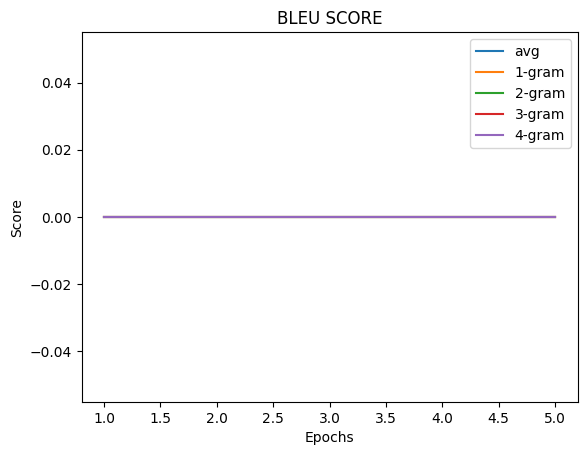

In [76]:
# 訓練模型
for epoch in range(num_epochs):
    train_losses = []
    test_losses = []
    bleu_scores = []

    start_time = time.time()
    train_loss = train(path='{}/MODELS/translation_model({}).pth'.format(dir_path,model_name))
    #break
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f'Epoch {epoch+1:02} | Train Time: {epoch_mins}m {epoch_secs}s')

    start_time = time.time()
    test_loss = evaluate()

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f'Epoch {epoch+1:02} | Test Time: {epoch_mins}m {epoch_secs}s')

    start_time = time.time()

    wandb.log({"Train_loss(epoch)": train_loss, 
               "Test_loss(epoch)": test_loss})
    
    samples = get_samples(TEST_ZSENT,TEST_KSENT,p=0.05)
    test_score = sacrebleu_score(model, source_sentences=samples['zh'],target_sentences=samples['ko'])
    #test_score = sacrebleu_score(model, source_sentences=TEST_ZSENT,target_sentences=TEST_KSENT,bpmf_sentences=TEST_ZYSENT,hanja_sentences=TEST_HSENT)
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    print(f'Epoch {epoch+1:02} | Eval Time: {epoch_mins}m {epoch_secs}s')
    
    print('\tTrain Loss: {:.3f} | Test Loss: {:.3f}'.format(train_loss, test_loss))
    print('\tBLEU Score:')
    for k in test_score.keys():
        print('\t\t{}: {:.3f}'.format(k,test_score[k]))
    #break
    #'''
    wandb.log({
               'BLEU_score(avg)':test_score['avg'],
               '1-gram':test_score['1-gram'],
               '2-gram':test_score['2-gram'],
               '3-gram':test_score['3-gram'],
               '4-gram':test_score['4-gram']})#'''

    # 儲存訓練好的模型
    if(test_score['avg'] > best_score or test_loss < best_loss):
       if(test_loss < best_loss):
          best_loss = test_loss
       if(test_score['avg'] > best_score):
          best_score = test_score['avg']
       torch.save(model.state_dict(), '{}/MODELS/best_translation_model({}).pth'.format(dir_path,model_name))
       print('== save model ==')

    print('\tTrain Loss: {:.3f} | Test Loss: {:.3f}'.format(train_loss, test_loss))
    print('\tBLEU Score:')
    for k in test_score.keys():
        print('\t\t{}: {:.3f}'.format(k,test_score[k]))

  

    if(best_score - test_score['avg'] > 3 or test_score['avg'] < 0.01):
      try:
        model.load_state_dict(torch.load('{}/MODELS/best_translation_model({}).pth'.format(dir_path,model_name)))
        print('='*5,'load best model','='*5)
      except:
        model = BertTranslator(my_model, hidden_dim=embed_size, target_vocab_size=tgt_vocab_size).to(device)
        print('-'*5,'initialize','-'*5)
          


    train_losses.append(train_loss)
    test_losses.append(test_loss)
    bleu_scores.append(test_score)

    loss_history(train_losses, test_losses, path=model_name, to_show=False)
    sacrebleu_history(bleu_scores, path=model_name, to_show=False)
wandb.finish()

In [71]:
bleu_score(test_source_sentences,model,tokenizer,max_length,device)

NameError: name 'bleu_score' is not defined

In [ ]:
from sacrebleu.metrics import BLEU

def sacrebleu_score(source_sentences,target_sentences,lang='ko'):
  global zh_tokenizer, ko_tokenizer, model, max_length, device
  model.eval()
  bleu = BLEU()
  bleu.trg_lang = lang
  avg_score = {'avg':0,'1-gram':0,'2-gram':0,'3-gram':0,'4-gram':0}

  # 生成目標語句
  generated_sentences = []
  with tqdm(total = len(source_sentences)) as pbar:
    for i in range(len(source_sentences)):
        source_sentence = source_sentences[i]
        target_sentence = target_sentences[i]
        source_tokens = zh_tokenizer(source_sentence, padding=True, truncation=True, return_tensors='pt', max_length=max_length).to(device)
        with torch.no_grad():
            output = model(input_ids=source_tokens.input_ids, attention_mask=source_tokens.attention_mask)
        generated_sentence = ko_tokenizer.decode(output[0].argmax(dim=-1), skip_special_tokens=True)
        gen_sent = ''
        for sent in generated_sentence:
            gen_sent += sent
        bleu_score = bleu.corpus_score([gen_sent],[[target_sentence]])
        #print([gen_sent],[[target_sentence]])
        #print(bleu_score)
        avg_score['avg'] += bleu_score.score
        avg_score['1-gram'] += bleu_score.precisions[0]
        avg_score['2-gram'] += bleu_score.precisions[1]
        avg_score['3-gram'] += bleu_score.precisions[2]
        avg_score['4-gram'] += bleu_score.precisions[3]
        pbar.update(1)
  avg_score['avg'] /= len(source_sentences)
  avg_score['1-gram'] /= len(source_sentences)
  avg_score['2-gram'] /= len(source_sentences)
  avg_score['3-gram'] /= len(source_sentences)
  avg_score['4-gram'] /= len(source_sentences)

  #print('gen:',generated_sentences,'tar:',[[sent] for sent in target_sentences],'sor',source_sentences)
  #print('BLEU Score:',bleu.score)

  return avg_score

In [ ]:
train_score = sacrebleu_score(TRAIN_ZSENT,TRAIN_KSENT)
test_score = sacrebleu_score(TEST_ZSENT,TEST_KSENT)
print('Train:',train_score)
print('Test:',test_score)